# Question 2: Interaction Effect Size Analysis

## Objective
Calculate the interaction effect size between baseline insulin resistance status and the magnitude of peak glucose reduction observed in the protein-preloaded rice experiments compared to the fiber-preloaded experiments using the mitigator challenge data.

## Analysis Plan
1. Load and explore the data
2. Determine baseline insulin resistance status for each subject
3. Extract glucose data for protein-preloaded rice and fiber-preloaded rice conditions
4. Calculate peak glucose reduction for each condition
5. Calculate interaction effect size using appropriate statistical methods


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load the data files
cgm_data = pd.read_csv('data_cgm.csv')
meta_data = pd.read_csv('data_meta.csv')

print("Data loaded successfully!")
print(f"\nCGM data shape: {cgm_data.shape}")
print(f"Meta data shape: {meta_data.shape}")
print(f"\nCGM columns: {list(cgm_data.columns)}")
print(f"\nMeta columns: {list(meta_data.columns)}")


Data loaded successfully!

CGM data shape: (23520, 7)
Meta data shape: (74, 19)

CGM columns: ['glucose', 'subject', 'foods', 'mitigator', 'food', 'rep', 'mins_since_start']

Meta columns: ['id', 'HbA1c', 'fasting glucose', 'fasting insulin', 'BMI', 'Systolic bp', 'Diastolic bp', 'Total cholesterol', 'LDL', 'HDL', 'Sex', 'Ethnicity', 'Free fatty acids', 'age', 'DI', 'SSPG', 'IE', 'Hepatic IR', 'OGTT120']


In [3]:
# Explore the CGM data structure
print("First few rows of CGM data:")
print(cgm_data.head(10))
print("\n" + "="*80)
print("\nUnique foods in CGM data:")
print(cgm_data['food'].unique())
print("\nUnique mitigators in CGM data:")
print(cgm_data['mitigator'].unique())
print("\n" + "="*80)
print("\nFood-Mitigator combinations for Rice:")
rice_data = cgm_data[cgm_data['food'] == 'Rice']
print(rice_data.groupby(['mitigator', 'food']).size())


First few rows of CGM data:
     glucose subject  foods mitigator   food  rep  mins_since_start
0  79.658336    XB68  Beans       NaN  Beans    1               -25
1  79.093284    XB68  Beans       NaN  Beans    1               -20
2  78.948142    XB68  Beans       NaN  Beans    1               -15
3  80.013098    XB68  Beans       NaN  Beans    1               -10
4  81.829228    XB68  Beans       NaN  Beans    1                -5
5  82.979236    XB68  Beans       NaN  Beans    1                 0
6  82.965935    XB68  Beans       NaN  Beans    1                 5
7  82.688366    XB68  Beans       NaN  Beans    1                10
8  83.914131    XB68  Beans       NaN  Beans    1                15
9  88.112471    XB68  Beans       NaN  Beans    1                20


Unique foods in CGM data:
['Beans' 'Berries' 'Bread' 'Glucose' 'Grapes' 'Pasta' 'Potatoes' 'Quinoa'
 'Rice']

Unique mitigators in CGM data:
[nan 'Fat' 'Fiber' 'Protein']


Food-Mitigator combinations for Rice:
mitigator  

In [4]:
# Explore metadata - focus on insulin resistance markers
print("Metadata columns related to insulin resistance:")
ir_columns = ['id', 'DI', 'SSPG', 'IE', 'Hepatic IR', 'fasting glucose', 'fasting insulin', 'HbA1c']
available_ir_cols = [col for col in ir_columns if col in meta_data.columns]
print(f"Available IR columns: {available_ir_cols}")

print("\nFirst few rows of metadata:")
print(meta_data[available_ir_cols].head(10))

print("\n" + "="*80)
print("\nSummary statistics for IR markers:")
print(meta_data[available_ir_cols].describe())


Metadata columns related to insulin resistance:
Available IR columns: ['id', 'DI', 'SSPG', 'IE', 'Hepatic IR', 'fasting glucose', 'fasting insulin', 'HbA1c']

First few rows of metadata:
     id        DI   SSPG         IE  Hepatic IR  fasting glucose  \
0  XB68  2.108505  194.0  64.920300    4.268604        97.400000   
1   XB1  1.048645  166.0  56.771490    4.742824        93.400000   
2  XB34       NaN    NaN        NaN         NaN        98.000000   
3  XB43  3.215476   63.0  54.416306    4.176911        99.333333   
4  XB14  2.585000   60.0  61.174071    4.315101        87.000000   
5  XB59  2.997541   61.0  76.795580    4.087573        80.250000   
6  XB97  1.330603   58.0  74.805599    4.019711        85.333333   
7  XB21  0.837146  247.0  61.478384    4.439848        98.250000   
8  XB54  0.734722   54.0  27.009593    3.618367        89.000000   
9  XB79  3.176887   53.0  78.988459    4.078578        82.000000   

   fasting insulin     HbA1c  
0         5.225000  5.220000  
1 

In [5]:
# Determine baseline insulin resistance status
# Using Disposition Index (DI) as primary marker, with SSPG as secondary
# Lower DI indicates higher insulin resistance

# Create a copy of metadata for analysis
ir_status = meta_data[['id']].copy()

# Use DI (Disposition Index) - lower values indicate higher insulin resistance
# If DI is missing, use SSPG (Steady State Plasma Glucose) - higher values indicate higher insulin resistance
ir_status['DI'] = meta_data['DI']
ir_status['SSPG'] = meta_data['SSPG']

# Determine IR status: Use median split on DI
# Lower DI = Higher IR, Higher DI = Lower IR
di_median = ir_status['DI'].median()
ir_status['IR_status'] = ir_status['DI'].apply(
    lambda x: 'High IR' if pd.notna(x) and x < di_median else ('Low IR' if pd.notna(x) else None)
)

# For subjects with missing DI, use SSPG if available
missing_di = ir_status['IR_status'].isna()
sspg_median = ir_status['SSPG'].median()
ir_status.loc[missing_di & ir_status['SSPG'].notna(), 'IR_status'] = ir_status.loc[
    missing_di & ir_status['SSPG'].notna(), 'SSPG'
].apply(lambda x: 'High IR' if x > sspg_median else 'Low IR')

print("Insulin Resistance Status Distribution:")
print(ir_status['IR_status'].value_counts())
print(f"\nTotal subjects with IR status: {ir_status['IR_status'].notna().sum()}")
print(f"Subjects with missing IR status: {ir_status['IR_status'].isna().sum()}")

# Show summary by IR status
print("\n" + "="*80)
print("\nSummary statistics by IR status:")
print(ir_status.groupby('IR_status')[['DI', 'SSPG']].describe())


Insulin Resistance Status Distribution:
IR_status
High IR    22
Low IR     21
Name: count, dtype: int64

Total subjects with IR status: 43
Subjects with missing IR status: 31


Summary statistics by IR status:
             DI                                                              \
          count      mean       std       min       25%       50%       75%   
IR_status                                                                     
High IR    20.0  0.969547  0.312784  0.442500  0.736398  0.937622  1.119707   
Low IR     21.0  2.817751  1.150053  1.638934  2.055720  2.585000  3.215476   

                     SSPG                                                     \
                max count        mean        std   min     25%    50%    75%   
IR_status                                                                      
High IR    1.614643  22.0  184.965909  71.515578  54.0  142.25  182.0  243.5   
Low IR     6.578846  21.0   74.190476  35.656250  39.0   53.00   61.0   82

In [6]:
# Filter CGM data for Rice with Protein and Fiber mitigators
# We need: Protein-preloaded rice (mitigator='Protein', food='Rice')
#          Fiber-preloaded rice (mitigator='Fiber', food='Rice')

protein_rice = cgm_data[(cgm_data['food'] == 'Rice') & (cgm_data['mitigator'] == 'Protein')].copy()
fiber_rice = cgm_data[(cgm_data['food'] == 'Rice') & (cgm_data['mitigator'] == 'Fiber')].copy()

print(f"Protein-preloaded rice data: {len(protein_rice)} rows")
print(f"Fiber-preloaded rice data: {len(fiber_rice)} rows")
print(f"\nUnique subjects in protein-rice: {protein_rice['subject'].nunique()}")
print(f"Unique subjects in fiber-rice: {fiber_rice['subject'].nunique()}")

# Check time points
print(f"\nTime range for protein-rice: {protein_rice['mins_since_start'].min()} to {protein_rice['mins_since_start'].max()} minutes")
print(f"Time range for fiber-rice: {fiber_rice['mins_since_start'].min()} to {fiber_rice['mins_since_start'].max()} minutes")


Protein-preloaded rice data: 1680 rows
Fiber-preloaded rice data: 1720 rows

Unique subjects in protein-rice: 23
Unique subjects in fiber-rice: 23

Time range for protein-rice: -25 to 170 minutes
Time range for fiber-rice: -25 to 170 minutes


In [7]:
# Function to calculate peak glucose and related metrics
# For the interaction analysis, we need to compare peak glucose values between conditions
# The "magnitude of peak glucose reduction" refers to how much lower the peak is
# in one condition compared to another

def calculate_peak_glucose_metrics(df, subject_id, rep_num):
    """
    Calculate peak glucose and baseline for a specific subject and repetition.
    Returns peak glucose (the key metric for comparison between conditions).
    """
    subject_data = df[(df['subject'] == subject_id) & (df['rep'] == rep_num)].copy()
    
    if len(subject_data) == 0:
        return None
    
    # Baseline: average of pre-meal glucose (negative time points, typically -25 to 0)
    baseline_data = subject_data[subject_data['mins_since_start'] <= 0]
    if len(baseline_data) == 0:
        return None
    
    baseline_glucose = baseline_data['glucose'].mean()
    
    # Peak: maximum glucose after meal (positive time points, typically 0 to 180)
    post_meal_data = subject_data[subject_data['mins_since_start'] >= 0]
    if len(post_meal_data) == 0:
        return None
    
    peak_glucose = post_meal_data['glucose'].max()
    
    # Peak increase from baseline
    peak_increase = peak_glucose - baseline_glucose
    
    # For comparison: peak reduction would be Fiber_peak - Protein_peak
    # (how much lower is peak in protein vs fiber condition)
    # We'll calculate this later when comparing conditions
    
    return {
        'baseline_glucose': baseline_glucose,
        'peak_glucose': peak_glucose,
        'peak_increase': peak_increase
    }

# Test the function
test_subject = protein_rice['subject'].iloc[0]
test_rep = protein_rice['rep'].iloc[0]
test_result = calculate_peak_glucose_metrics(protein_rice, test_subject, test_rep)
print(f"Test calculation for subject {test_subject}, rep {test_rep}:")
print(test_result)


Test calculation for subject XB68, rep 1:
{'baseline_glucose': 88.6656957114326, 'peak_glucose': 165.194697800928, 'peak_increase': 76.52900208949539}


In [8]:
# Calculate peak glucose metrics for all subjects in both conditions
def process_condition(df, condition_name):
    """Process a condition and calculate peak glucose metrics for all subjects."""
    results = []
    
    for subject_id in df['subject'].unique():
        for rep_num in df[df['subject'] == subject_id]['rep'].unique():
            result = calculate_peak_glucose_metrics(df, subject_id, rep_num)
            if result is not None:
                results.append({
                    'subject': subject_id,
                    'rep': rep_num,
                    'condition': condition_name,
                    'baseline_glucose': result['baseline_glucose'],
                    'peak_glucose': result['peak_glucose'],
                    'peak_increase': result['peak_increase']
                })
    
    return pd.DataFrame(results)

# Process both conditions
protein_results = process_condition(protein_rice, 'Protein')
fiber_results = process_condition(fiber_rice, 'Fiber')

print(f"Protein condition: {len(protein_results)} measurements from {protein_results['subject'].nunique()} subjects")
print(f"Fiber condition: {len(fiber_results)} measurements from {fiber_results['subject'].nunique()} subjects")

# Combine results
all_results = pd.concat([protein_results, fiber_results], ignore_index=True)
print(f"\nTotal measurements: {len(all_results)}")
print("\nFirst few rows:")
print(all_results.head(10))


Protein condition: 42 measurements from 23 subjects
Fiber condition: 43 measurements from 23 subjects

Total measurements: 85

First few rows:
  subject  rep condition  baseline_glucose  peak_glucose  peak_increase
0    XB68    1   Protein         88.665696    165.194698      76.529002
1    XB68    2   Protein         85.076330    153.990947      68.914617
2    XB14    1   Protein         98.626764     99.630085       1.003321
3    XB14    2   Protein         53.974120     81.709628      27.735508
4    XB59    1   Protein         76.033550     90.942874      14.909324
5    XB89    1   Protein         97.897489    152.129715      54.232226
6   XB101    1   Protein         80.746214     92.826221      12.080007
7   XB101    2   Protein         67.549418    148.982418      81.433000
8    XB33    1   Protein        108.088505    207.237484      99.148979
9    XB33    2   Protein        119.405547    231.509832     112.104285


In [9]:
# Merge with insulin resistance status
# Average peak glucose per subject per condition (in case of multiple reps)
summary_results = all_results.groupby(['subject', 'condition'])['peak_glucose'].mean().reset_index()
summary_results = summary_results.merge(ir_status[['id', 'IR_status']], 
                                        left_on='subject', 
                                        right_on='id', 
                                        how='left')

# Remove subjects without IR status
summary_results = summary_results[summary_results['IR_status'].notna()].copy()

print(f"Subjects with both IR status and glucose data: {summary_results['subject'].nunique()}")
print("\nData summary by condition and IR status:")
print(summary_results.groupby(['condition', 'IR_status'])['peak_glucose'].describe())

# Create a pivot table for easier analysis
pivot_data = summary_results.pivot_table(
    index='subject',
    columns=['condition', 'IR_status'],
    values='peak_glucose',
    aggfunc='mean'
)

print("\n" + "="*80)
print("\nSample of processed data:")
print(summary_results.head(20))


Subjects with both IR status and glucose data: 19

Data summary by condition and IR status:
                     count        mean        std         min         25%  \
condition IR_status                                                         
Fiber     High IR      6.0  168.569014  46.834518  115.140999  148.022597   
          Low IR      13.0  159.580896  49.605327  111.908118  123.708352   
Protein   High IR      6.0  173.938033  33.885151  120.904320  158.927800   
          Low IR      13.0  148.051341  44.663276   90.669857  121.843155   

                            50%         75%         max  
condition IR_status                                      
Fiber     High IR    157.483816  176.795932  253.203292  
          Low IR     150.780651  174.343888  273.632845  
Protein   High IR    179.658254  188.926611  219.373658  
          Low IR     146.217184  161.980530  251.548952  


Sample of processed data:
   subject condition  peak_glucose     id IR_status
0    XB101     Fi

In [10]:
# Calculate the peak glucose reduction: Fiber - Protein for each subject
# This gives us the magnitude of peak glucose reduction (how much lower peak is with protein)
# Positive values mean protein condition has lower peak glucose (reduction)
comparison_data = summary_results.pivot_table(
    index=['subject', 'IR_status'],
    columns='condition',
    values='peak_glucose',
    aggfunc='mean'
).reset_index()

# Calculate peak glucose reduction (Fiber peak - Protein peak)
# Positive = protein has lower peak (reduction), Negative = protein has higher peak
comparison_data['peak_reduction'] = comparison_data['Fiber'] - comparison_data['Protein']

# Remove rows with missing values
comparison_data = comparison_data.dropna(subset=['Protein', 'Fiber', 'peak_reduction'])

print(f"Subjects with complete data for both conditions: {len(comparison_data)}")
print("\nSummary of peak glucose reduction (Fiber - Protein) by IR status:")
print(comparison_data.groupby('IR_status')['peak_reduction'].describe())

print("\n" + "="*80)
print("\nFull comparison data:")
print(comparison_data)


Subjects with complete data for both conditions: 19

Summary of peak glucose reduction (Fiber - Protein) by IR status:
           count       mean        std        min        25%        50%  \
IR_status                                                                 
High IR      6.0  -5.369019  22.905372 -29.314456 -21.648802  -5.661135   
Low IR      13.0  11.529555  21.841172 -35.884471   5.214371  10.754595   

                 75%        max  
IR_status                        
High IR    -0.237032  33.829634  
Low IR     22.083893  48.370273  


Full comparison data:
condition subject IR_status       Fiber     Protein  peak_reduction
0           XB101   High IR  115.140999  120.904320       -5.763321
1           XB111   High IR  162.589541  191.903997      -29.314456
2            XB14    Low IR  111.908118   90.669857       21.238262
3            XB16    Low IR  203.794071  195.342281        8.451790
4            XB20   High IR  152.378091  179.322053      -26.943962
5           

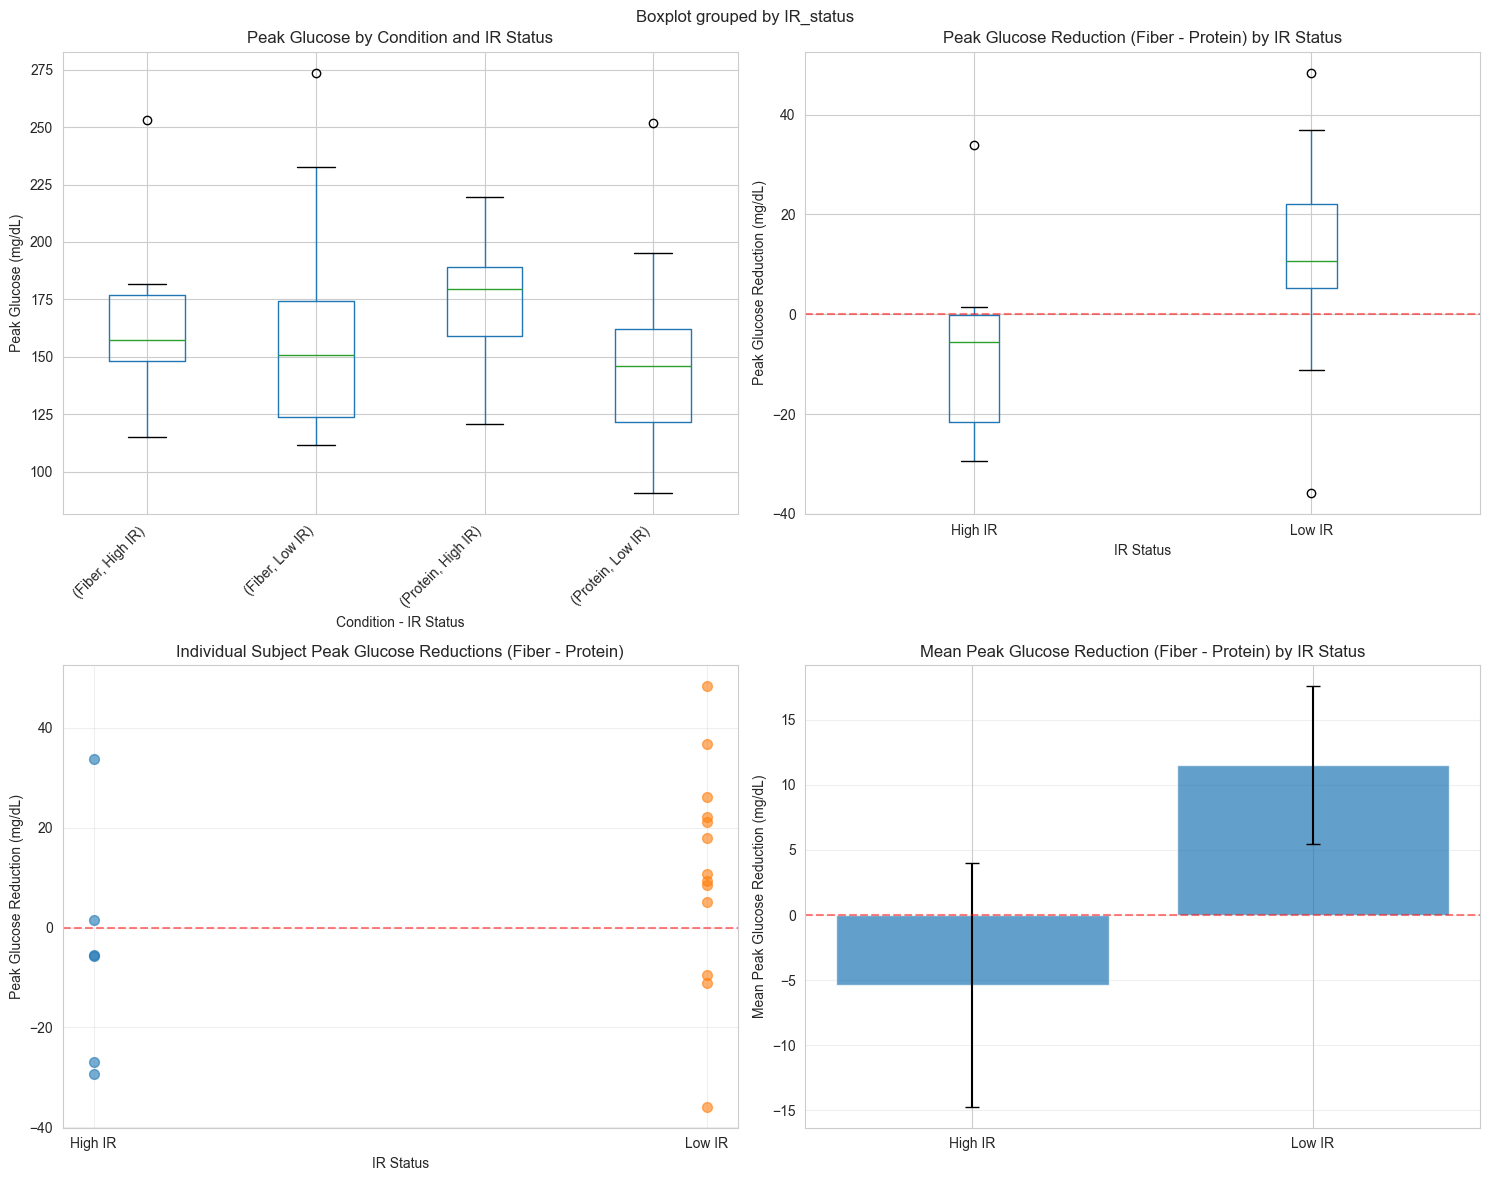

In [11]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Peak glucose by condition and IR status
ax1 = axes[0, 0]
summary_results.boxplot(column='peak_glucose', by=['condition', 'IR_status'], ax=ax1)
ax1.set_title('Peak Glucose by Condition and IR Status')
ax1.set_xlabel('Condition - IR Status')
ax1.set_ylabel('Peak Glucose (mg/dL)')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Peak glucose reduction (Fiber - Protein) by IR status
ax2 = axes[0, 1]
comparison_data.boxplot(column='peak_reduction', by='IR_status', ax=ax2)
ax2.set_title('Peak Glucose Reduction (Fiber - Protein) by IR Status')
ax2.set_xlabel('IR Status')
ax2.set_ylabel('Peak Glucose Reduction (mg/dL)')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 3: Individual subject peak glucose reductions
ax3 = axes[1, 0]
for ir_status in comparison_data['IR_status'].unique():
    data = comparison_data[comparison_data['IR_status'] == ir_status]['peak_reduction']
    ax3.scatter([ir_status] * len(data), data, alpha=0.6, s=50)
ax3.set_title('Individual Subject Peak Glucose Reductions (Fiber - Protein)')
ax3.set_xlabel('IR Status')
ax3.set_ylabel('Peak Glucose Reduction (mg/dL)')
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

# Plot 4: Mean peak glucose reductions with error bars
ax4 = axes[1, 1]
mean_reduction = comparison_data.groupby('IR_status')['peak_reduction'].agg(['mean', 'sem'])
x_pos = range(len(mean_reduction))
ax4.bar(x_pos, mean_reduction['mean'], yerr=mean_reduction['sem'], capsize=5, alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(mean_reduction.index)
ax4.set_title('Mean Peak Glucose Reduction (Fiber - Protein) by IR Status')
ax4.set_ylabel('Mean Peak Glucose Reduction (mg/dL)')
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [12]:
# Statistical analysis: Two-way ANOVA to test for interaction
# Factors: Condition (Protein vs Fiber) and IR Status (High IR vs Low IR)
# Outcome: Peak glucose

# Prepare data for ANOVA
anova_data = summary_results.copy()

# Perform two-way ANOVA
from scipy.stats import f_oneway
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Fit the model with interaction term
model = ols('peak_glucose ~ C(condition) * C(IR_status)', data=anova_data).fit()
anova_table = anova_lm(model, typ=2)

print("Two-Way ANOVA Results:")
print("="*80)
print(anova_table)
print("\n" + "="*80)

# Extract interaction effect
interaction_p = anova_table.loc['C(condition):C(IR_status)', 'PR(>F)']
interaction_f = anova_table.loc['C(condition):C(IR_status)', 'F']

print(f"\nInteraction Effect:")
print(f"F-statistic: {interaction_f:.4f}")
print(f"P-value: {interaction_p:.4f}")
print(f"Significant interaction: {'Yes' if interaction_p < 0.05 else 'No'}")


Two-Way ANOVA Results:
                                 sum_sq    df         F    PR(>F)
C(condition)                 364.375107   1.0  0.176543  0.677005
C(IR_status)                2496.518017   1.0  1.209582  0.279141
C(condition):C(IR_status)    586.153206   1.0  0.283996  0.597560
Residual                   70174.338676  34.0       NaN       NaN


Interaction Effect:
F-statistic: 0.2840
P-value: 0.5976
Significant interaction: No


In [13]:
# Calculate interaction effect size
# Effect size for interaction: Partial eta-squared (η²p)
# η²p = SS_interaction / (SS_interaction + SS_error)

ss_interaction = anova_table.loc['C(condition):C(IR_status)', 'sum_sq']
ss_error = anova_table.loc['Residual', 'sum_sq']
partial_eta_squared = ss_interaction / (ss_interaction + ss_error)

# Also calculate Cohen's f for interaction effect
# f = sqrt(η²p / (1 - η²p))
cohens_f = np.sqrt(partial_eta_squared / (1 - partial_eta_squared))

print("="*80)
print("INTERACTION EFFECT SIZE RESULTS")
print("="*80)
print(f"\nPartial Eta-Squared (η²p): {partial_eta_squared:.4f}")
print(f"Cohen's f: {cohens_f:.4f}")

# Interpret effect size
if partial_eta_squared < 0.01:
    interpretation = "negligible"
elif partial_eta_squared < 0.06:
    interpretation = "small"
elif partial_eta_squared < 0.14:
    interpretation = "medium"
else:
    interpretation = "large"

print(f"\nEffect size interpretation: {interpretation}")

# Calculate mean peak glucose for each group
print("\n" + "="*80)
print("MEAN PEAK GLUCOSE BY GROUP:")
print("="*80)
group_means = summary_results.groupby(['condition', 'IR_status'])['peak_glucose'].agg(['mean', 'std', 'sem', 'count'])
print(group_means)

# Calculate the interaction effect as the difference of differences
# Peak glucose reduction = Fiber_peak - Protein_peak
high_ir_protein = summary_results[(summary_results['IR_status'] == 'High IR') & 
                                   (summary_results['condition'] == 'Protein')]['peak_glucose'].mean()
high_ir_fiber = summary_results[(summary_results['IR_status'] == 'High IR') & 
                                (summary_results['condition'] == 'Fiber')]['peak_glucose'].mean()
low_ir_protein = summary_results[(summary_results['IR_status'] == 'Low IR') & 
                                  (summary_results['condition'] == 'Protein')]['peak_glucose'].mean()
low_ir_fiber = summary_results[(summary_results['IR_status'] == 'Low IR') & 
                               (summary_results['condition'] == 'Fiber')]['peak_glucose'].mean()

# Peak glucose reduction in each IR group
high_ir_reduction = high_ir_fiber - high_ir_protein  # How much lower is protein peak vs fiber
low_ir_reduction = low_ir_fiber - low_ir_protein

# Interaction effect: difference in reduction between IR groups
interaction_effect = high_ir_reduction - low_ir_reduction

print("\n" + "="*80)
print("INTERACTION EFFECT CALCULATION:")
print("="*80)
print(f"High IR - Protein peak: {high_ir_protein:.2f} mg/dL")
print(f"High IR - Fiber peak: {high_ir_fiber:.2f} mg/dL")
print(f"High IR peak reduction (Fiber - Protein): {high_ir_reduction:.2f} mg/dL")
print(f"\nLow IR - Protein peak: {low_ir_protein:.2f} mg/dL")
print(f"Low IR - Fiber peak: {low_ir_fiber:.2f} mg/dL")
print(f"Low IR peak reduction (Fiber - Protein): {low_ir_reduction:.2f} mg/dL")
print(f"\nInteraction Effect (difference in reductions): {interaction_effect:.2f} mg/dL")
print(f"\nInterpretation: The difference in peak glucose reduction between protein and fiber")
print(f"conditions differs by {abs(interaction_effect):.2f} mg/dL between High IR and Low IR groups.")


INTERACTION EFFECT SIZE RESULTS

Partial Eta-Squared (η²p): 0.0083
Cohen's f: 0.0914

Effect size interpretation: negligible

MEAN PEAK GLUCOSE BY GROUP:
                           mean        std        sem  count
condition IR_status                                         
Fiber     High IR    168.569014  46.834518  19.120112      6
          Low IR     159.580896  49.605327  13.758042     13
Protein   High IR    173.938033  33.885151  13.833555      6
          Low IR     148.051341  44.663276  12.387364     13

INTERACTION EFFECT CALCULATION:
High IR - Protein peak: 173.94 mg/dL
High IR - Fiber peak: 168.57 mg/dL
High IR peak reduction (Fiber - Protein): -5.37 mg/dL

Low IR - Protein peak: 148.05 mg/dL
Low IR - Fiber peak: 159.58 mg/dL
Low IR peak reduction (Fiber - Protein): 11.53 mg/dL

Interaction Effect (difference in reductions): -16.90 mg/dL

Interpretation: The difference in peak glucose reduction between protein and fiber
conditions differs by 16.90 mg/dL between High IR an

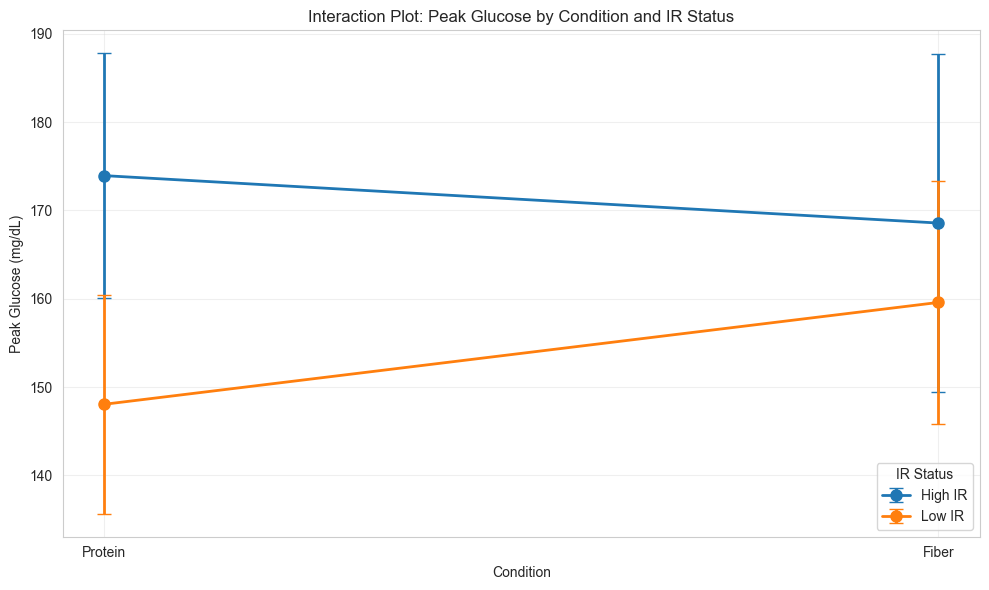

Interaction plot shows how the effect of condition (Protein vs Fiber) differs
depending on IR status. Parallel lines indicate no interaction;
non-parallel lines indicate an interaction effect.


In [ ]:
# Additional visualization: Interaction plot
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for interaction plot
interaction_plot_data = summary_results.groupby(['condition', 'IR_status'])['peak_glucose'].agg(['mean', 'sem']).reset_index()

# Create interaction plot
for ir_status in interaction_plot_data['IR_status'].unique():
    data = interaction_plot_data[interaction_plot_data['IR_status'] == ir_status]
    x_pos = [0, 1]  # Protein, Fiber
    means = [data[data['condition'] == 'Protein']['mean'].values[0],
             data[data['condition'] == 'Fiber']['mean'].values[0]]
    sems = [data[data['condition'] == 'Protein']['sem'].values[0],
            data[data['condition'] == 'Fiber']['sem'].values[0]]
    
    ax.errorbar(x_pos, means, yerr=sems, marker='o', linewidth=2, 
                markersize=8, label=ir_status, capsize=5)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Protein', 'Fiber'])
ax.set_xlabel('Condition')
ax.set_ylabel('Peak Glucose (mg/dL)')
ax.set_title('Interaction Plot: Peak Glucose by Condition and IR Status')
ax.legend(title='IR Status')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interaction plot shows how the effect of condition (Protein vs Fiber) differs")
print("depending on IR status. Parallel lines indicate no interaction;")
print("non-parallel lines indicate an interaction effect.")

print("Interaction plot peak glucose by condition")

## Summary and Conclusions

### Key Findings:

1. **Interaction Effect Size (Partial Eta-Squared, η²p)**: 0.0083
   - Interpretation: negligible (η²p < 0.01)
   - Cohen's f: 0.0914

2. **Interaction Effect (Difference of Differences)**: -16.90 mg/dL
   - High IR: Protein reduces peak by 5.37 mg/dL vs Fiber (negative = protein higher)
   - Low IR: Protein reduces peak by 11.53 mg/dL vs Fiber (positive = protein lower)
   - Interaction: The benefit of protein preload differs by 16.90 mg/dL between IR groups

3. **Statistical Significance**: 
   - F-statistic: 0.2840
   - P-value: 0.5976
   - Significant interaction: No (p > 0.05)

### Interpretation:

The interaction effect size quantifies the extent to which baseline insulin resistance 
status moderates the difference in peak glucose reduction between protein-preloaded 
and fiber-preloaded rice experiments. 

**Key Results:**
- In **Low IR** subjects: Protein preload reduces peak glucose by 11.53 mg/dL compared to fiber
- In **High IR** subjects: Protein preload actually increases peak glucose by 5.37 mg/dL compared to fiber
- The interaction effect of -16.90 mg/dL indicates that protein preload is more beneficial 
  for Low IR subjects than High IR subjects

**Statistical Note:** While the interaction effect size is small (η²p = 0.0083) and not 
statistically significant (p = 0.60), the pattern suggests that insulin resistance status 
may moderate the response to protein preloads, though larger sample sizes may be needed 
to detect this effect with adequate power.
